# Create data to train a BeatFinder model

This notebook shows how to record beats on a piece of music to train a BeatFinder model.

In [1]:
import beatfinder
import librosa
import librosa.display
from IPython.display import Audio
import time
import matplotlib.pyplot as plt
import numpy as np

sr = beatfinder.constants.sr
hl = beatfinder.constants.hl

Take any audio file:

In [27]:
audio_file = './data/JAZZ/audio/keith-jarrett/bye-bye-blackbird-01.m4a'

total_duration = librosa.get_duration(filename=audio_file)
print(f'Total duration: {total_duration:.2f} seconds')

Total duration: 674.00 seconds


Load all, or part of it:

In [84]:
offset = 150
duration = 60
wav = librosa.load(audio_file, sr, offset=offset, duration=duration)[0]

The next script slows down the audio file to half speed and put 12 clicks at the begining.

In [85]:
calibration_path = './data/tmp/calibration.wav'

n = 12                       # Number of beats played before the song starts to calibrate.
bpm = 120                    # BPM of those beats.
period = int(sr * 60 / bpm)  # samples per beat
stretch = 2                  # factor by which to stretch the wav (int)
click_volume = 4

calibration_beats_times = np.arange(1, n + 1, dtype=np.float) * period / sr
clicks = librosa.clicks(calibration_beats_times, sr=sr, length=(n+1)*period)
start_time = len(clicks) / sr
clicks *= click_volume / 10
wav_stretched = np.repeat(wav, stretch)
calibration_wav = np.concatenate((clicks, wav_stretched))
librosa.output.write_wav(calibration_path, calibration_wav, sr)

Now, run
```
python ./beatfinder/recored-beats.py ./data/tmp/
```
on a command line and listen to `./data/tmp/calibration.wav` (e.g. on mac, run `afplay ./data/tmp/calibration.wav` on another terminal session). The calibration audio starts with 12 clicks at 120 BPM. Listen to the first 4 and press enter at the same time of the other 8 (this is to make sure the recording is well aligned with the audio file). Then, the audio will play at half speed. Press enter on the beats of the music.

Load the beats recorded:

In [73]:
beats_times_recorded = np.loadtxt('./data/tmp/beats.txt')

The next script aligns the recording with the audio file. If it successed, you should see 12 red lines on the bottom, and 8 blue lines on top aligned on the last 8 red lines.

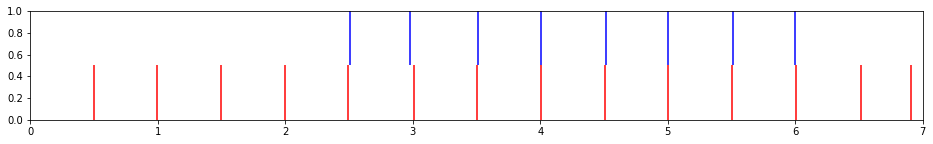

In [74]:
calibration_onsets_env = beatfinder.utils.onset_strength(wav=calibration_wav)
calibration_onsets = beatfinder.utils.peak_detect(calibration_onsets_env)
calibration_onsets_times = librosa.frames_to_time(calibration_onsets, sr, hl)
calibration_offset = (beats_times_recorded[:n - 4] - calibration_onsets_times[4:n]).mean()
calibration_beats_times = beats_times_recorded - calibration_offset

beats_times = (calibration_beats_times[calibration_beats_times > start_time] - start_time) / stretch

plt.figure(figsize=(16, 2))
plt.vlines(calibration_beats_times, 0.5, 1, color='b', linestyle='-', label='Beats recorded')
plt.vlines(calibration_onsets_times, 0, 0.5, color='r', linestyle='-', label='Onsets detected')
plt.xlim(0, 7)
plt.ylim(0, 1);

See what you recorded (you can change `plt.xlim` to view different parts):

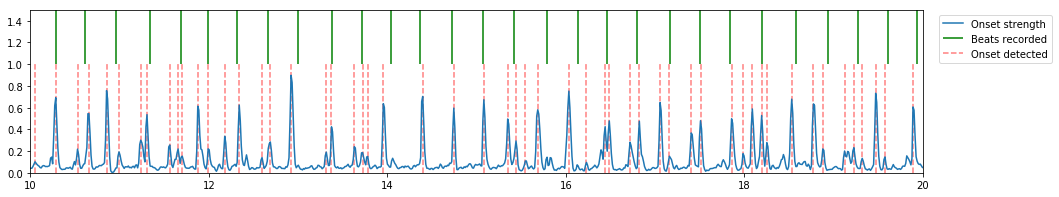

In [75]:
onsets_env = beatfinder.utils.onset_strength(wav=wav)
onsets = beatfinder.utils.peak_detect(onsets_env)
times        = librosa.frames_to_time(np.arange(len(onsets_env)), sr, hl)
onsets_times = librosa.frames_to_time(onsets, sr, hl)

plt.figure(figsize=(16, 3))
plt.vlines(beats_times, 1, 1.5, color='g', linestyle='-', label='Beats recorded')
plt.vlines(onsets_times, 0, 1, alpha=0.5, color='r', linestyle='--', label='Onset detected')
plt.plot(times, onsets_env, label='Onset strength')
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1))
plt.ylim(0, 1.5)
plt.xlim(10, 20);

Or also listen to it:

In [76]:
Audio(beatfinder.display.clicks(wav, beats_times, clicks_volume=4), rate=sr)

Now, since its hard to record beats perfectly, we run a script that will realign our recorded beats on the onsets. 

We first go over each recored beat and check if there is an onset close enough to it.

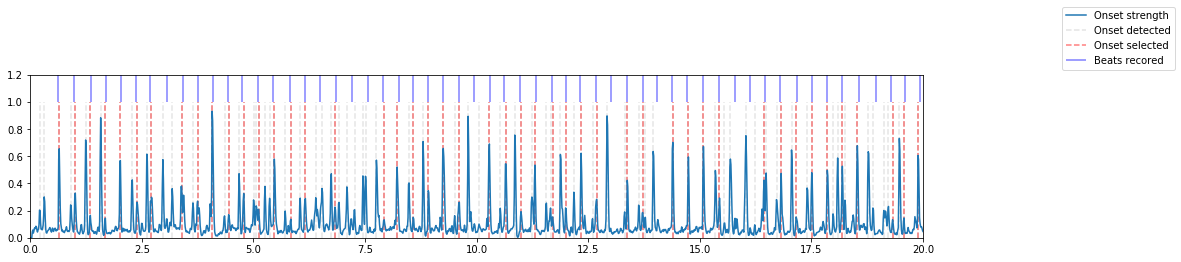

In [77]:
selected_idxs = beatfinder.utils.select_onsets(onsets_times, beats_times)
selected_onsets = onsets[selected_idxs]
selected_onsets_times = onsets_times[selected_idxs]

plt.figure(figsize=(16, 3))
plt.plot(times, librosa.util.normalize(onsets_env), label='Onset strength')
plt.vlines(onsets_times, 0, 1, alpha=0.1, color='k', linestyle='--', label='Onset detected')
plt.vlines(selected_onsets_times, 0, 1, alpha=0.5, color='r', linestyle='--', label='Onset selected')
plt.vlines(beats_times, 1, 1.3, alpha=0.5, color='b', linestyle='-', label='Beats recored')
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1))
plt.ylim(0, 1.2);
plt.xlim(0, 20);

Now, we use the dynamic programming beat tracking to complete those selected onsets to a beat track. To accomodate for a varying tempo, we do this on subsambles of length `sample_length`. If it doesn't work or there is a huge jump in the BPMs, change `sample_length` to a larger value.

In [78]:
sample_length = 10
overlap = 2
N = int(duration / (sample_length - overlap))
print(f'Number of samples: {N}')

Number of samples: 7


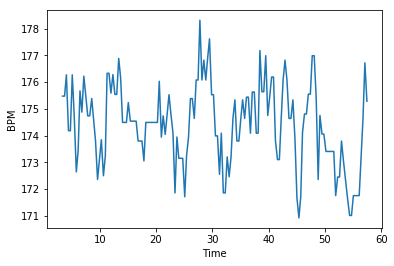

In [79]:
bts = []
for i in range(N):
    start_time = i * (sample_length - overlap)
    end_time   = start_time + sample_length
    b = beats_times[(start_time <= beats_times) & (beats_times < end_time)]
    bf = librosa.time_to_frames(b, sr, hl)
    bpm = beatfinder.utils.bpm_estimation(bf, show_plot=False)
    start = librosa.time_to_frames(start_time, sr, hl)
    end   = librosa.time_to_frames(end_time, sr, hl)
    so = selected_onsets[(start <= selected_onsets) & (selected_onsets < end)]
    cb, _ = beatfinder.utils.beat_track(so, 1000, bpm)
    if i == 0:
        bts += list(cb[:-2])
    elif i == N - 1:
        bts += list(cb[cb > bts[-1]])
    else:
        bts += list(cb[cb > bts[-1]][:-2])
beats = np.array(bts)[1:] - hl / sr

bpms = 60 / (beats[1:] - beats[:-1])
a = 8
avs = [bpms[i: i + a].mean() for i in range(len(bpms) - a)]
plt.xlabel('Time')
plt.ylabel('BPM')
plt.plot(beats[a:-1], avs);

In [80]:
selected_idx = beatfinder.utils.select_onsets(onsets_times, beats)
selected_onsets_times = onsets_times[selected_idx]

Take a look at the result:

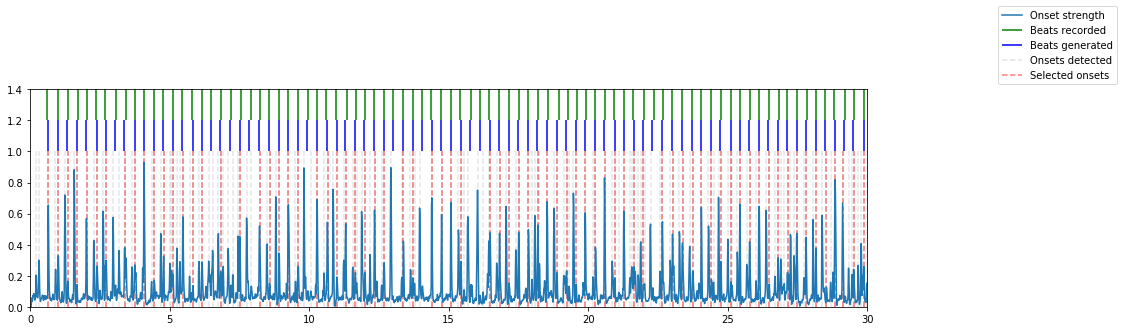

In [81]:
plt.figure(figsize=(15, 4))
plt.vlines(beats_times, 1.2, 1.4, color='g', linestyle='-', label='Beats recorded')
plt.vlines(beats, 1, 1.2, color='b', linestyle='-', label='Beats generated')
plt.vlines(onsets_times, 0, 1, alpha=0.1, color='k', linestyle='--', label='Onsets detected')
plt.vlines(selected_onsets_times, 0, 1, alpha=0.5, color='r', linestyles='--', label='Selected onsets')
plt.plot(times, onsets_env, label='Onset strength')
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1))
plt.ylim(0, 1.4);
plt.xlim(0, 30);

Listen to the result:

In [82]:
Audio(beatfinder.display.clicks(wav, beats, clicks_volume=4), rate=sr)

And save it somewhere:

In [83]:
np.savetxt('./data/JAZZ/beats/bye-bye-blackbird-01.100-160.beats', beats)

It's easier to do this on little chunks and join the files after:

In [107]:
beats_files = [
    './data/JAZZ/beats/bye-bye-blackbird-01.00-60.beats',
    './data/JAZZ/beats/bye-bye-blackbird-01.50-110.beats',
    './data/JAZZ/beats/bye-bye-blackbird-01.100-160.beats'
]
offsets = [
    0,
    50,
    100
]

beats = []
for i, bf in enumerate(beats_files):
    b = np.loadtxt(bf) + offsets[i]
    if i == 0:
        b = b[:-2]
    elif i == len(beats_files) - 1:
        b = b[b > beats[-1]]
    else:
        b = b[b > beats[-1]][:-2]
    beats += list(b)
beats = np.array(beats)

In [111]:
np.savetxt('./data/JAZZ/beats/bye-bye-blackbird-01.0-160.beats', beats)